In [1]:
import glob
import os
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [2]:
def find_csv_files(log_dir, algos, filename) -> list[Path]:
    # Matches …/<SEED>/debug/**/finetuning_eval.csv  (depth under debug doesn't matter)
    
    csv_files = defaultdict(lambda: defaultdict(dict))
    for algo, env_name, dataset_size, exp_log_dir in algos:
        pattern = os.path.join(log_dir, algo, exp_log_dir, "*", "debug", "**", filename)
        files = [p for p in glob.glob(pattern, recursive=True)]
        csv_files[env_name][algo][int(dataset_size)] = files 
    return csv_files


log_dir = "/n/fs/rl-chongyiz/exp_logs/ogbench_logs"
algos = [
    ("sarsa_ifql_vib_gpi_offline2offline", "cheetah_run", "1_000", "20250513_sarsa_ifql_vib_gpi_offline2offline_cheetah_run_obs_norm=normal_alpha=0.3_ft_size=1000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.9_actor_ln=False_kl_weight=0.05_latent_dim=128"),
    ("sarsa_ifql_vib_gpi_offline2offline", "cheetah_run", "5_000", "20250513_sarsa_ifql_vib_gpi_offline2offline_cheetah_run_obs_norm=normal_alpha=0.3_ft_size=5000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.9_actor_ln=False_kl_weight=0.05_latent_dim=128"),
    ("sarsa_ifql_vib_gpi_offline2offline", "cheetah_run", "10_000", "20250513_sarsa_ifql_vib_gpi_offline2offline_cheetah_run_obs_norm=normal_alpha=0.3_ft_size=10000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.9_actor_ln=False_kl_weight=0.05_latent_dim=128"),
    ("sarsa_ifql_vib_gpi_offline2offline", "cheetah_run", "25_000", "20250513_sarsa_ifql_vib_gpi_offline2offline_cheetah_run_obs_norm=normal_alpha=0.3_ft_size=25000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.9_actor_ln=False_kl_weight=0.05_latent_dim=128"),
    ("sarsa_ifql_vib_gpi_offline2offline", "cheetah_run", "50_000", "20250513_sarsa_ifql_vib_gpi_offline2offline_cheetah_run_obs_norm=normal_alpha=0.3_ft_size=50000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.9_actor_ln=False_kl_weight=0.05_latent_dim=128"),
    # ("rebrac_offline2offline", "cheetah_run", "1_000", "20250513_rebrac_offline2offline_cheetah_run_obs_norm_type=normal_alpha_actor=0.1_alpha_critic=0.1_ft_size=1000_ft_steps=500000_eval_freq=10000_actor_freq=4"),
    # ("rebrac_offline2offline", "cheetah_run", "5_000", "20250513_rebrac_offline2offline_cheetah_run_obs_norm_type=normal_alpha_actor=0.1_alpha_critic=0.1_ft_size=5000_ft_steps=500000_eval_freq=10000_actor_freq=4"),
    # ("rebrac_offline2offline", "cheetah_run", "10_000", "20250513_rebrac_offline2offline_cheetah_run_obs_norm_type=normal_alpha_actor=0.1_alpha_critic=0.1_ft_size=10000_ft_steps=500000_eval_freq=10000_actor_freq=4"),
    # ("rebrac_offline2offline", "cheetah_run", "25_000", "20250513_rebrac_offline2offline_cheetah_run_obs_norm_type=normal_alpha_actor=0.1_alpha_critic=0.1_ft_size=25000_ft_steps=500000_eval_freq=10000_actor_freq=4"),
    # ("rebrac_offline2offline", "cheetah_run", "50_000", "20250513_rebrac_offline2offline_cheetah_run_obs_norm_type=normal_alpha_actor=0.1_alpha_critic=0.1_ft_size=50000_ft_steps=500000_eval_freq=10000_actor_freq=4"),
    
    ("sarsa_ifql_vib_gpi_offline2offline", "quadruped_jump", "5_000", "20250727_sarsa_ifql_vib_gpi_offline2offline_quadruped_jump_obs_norm=normal_alpha=0.3_ft_size=5000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.9_actor_ln=False_kl_weight=0.005_latent_dim=128"),
    ("sarsa_ifql_vib_gpi_offline2offline", "quadruped_jump", "10_000", "20250727_sarsa_ifql_vib_gpi_offline2offline_quadruped_jump_obs_norm=normal_alpha=0.3_ft_size=10000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.9_actor_ln=False_kl_weight=0.005_latent_dim=128"),
    ("sarsa_ifql_vib_gpi_offline2offline", "quadruped_jump", "25_000", "20250727_sarsa_ifql_vib_gpi_offline2offline_quadruped_jump_obs_norm=normal_alpha=0.3_ft_size=25000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.9_actor_ln=False_kl_weight=0.005_latent_dim=128"),
    ("sarsa_ifql_vib_gpi_offline2offline", "quadruped_jump", "50_000", "20250727_sarsa_ifql_vib_gpi_offline2offline_quadruped_jump_obs_norm=normal_alpha=0.3_ft_size=50000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.9_actor_ln=False_kl_weight=0.005_latent_dim=128"),
    ("sarsa_ifql_vib_gpi_offline2offline", "quadruped_jump", "100_000", "20250727_sarsa_ifql_vib_gpi_offline2offline_quadruped_jump_obs_norm=normal_alpha=0.3_ft_size=100000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.9_actor_ln=False_kl_weight=0.005_latent_dim=128"),
    ("sarsa_ifql_vib_gpi_offline2offline", "quadruped_jump", "250_000", "20250727_sarsa_ifql_vib_gpi_offline2offline_quadruped_jump_obs_norm=normal_alpha=0.3_ft_size=250000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.9_actor_ln=False_kl_weight=0.005_latent_dim=128"),
    ("sarsa_ifql_vib_gpi_offline2offline", "quadruped_jump", "500_000", "20250727_sarsa_ifql_vib_gpi_offline2offline_quadruped_jump_obs_norm=normal_alpha=0.3_ft_size=500000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.9_actor_ln=False_kl_weight=0.005_latent_dim=128"),

    # 5_000, 10_000, 25_000, 50_000, 100_000, 250_000, 500_000
    ("sarsa_ifql_vib_gpi_offline2offline", "cube-single-play-singletask-task2", "5_000", "20250727_sarsa_ifql_vib_gpi_offline2offline_cube-single-play-singletask-task2-v0_obs_norm=normal_alpha=30.0_ft_size=5000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.95_actor_ln=False_kl_weight=0.05_latent_dim=512_value_ln=True"),
    ("sarsa_ifql_vib_gpi_offline2offline", "cube-single-play-singletask-task2", "10_000", "20250727_sarsa_ifql_vib_gpi_offline2offline_cube-single-play-singletask-task2-v0_obs_norm=normal_alpha=30.0_ft_size=10000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.95_actor_ln=False_kl_weight=0.05_latent_dim=512_value_ln=True"),
    ("sarsa_ifql_vib_gpi_offline2offline", "cube-single-play-singletask-tsak2", "25_000", "20250727_sarsa_ifql_vib_gpi_offline2offline_cube-single-play-singletask-task2-v0_obs_norm=normal_alpha=30.0_ft_size=25000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.95_actor_ln=False_kl_weight=0.05_latent_dim=512_value_ln=True"),
    ("sarsa_ifql_vib_gpi_offline2offline", "cube-single-play-singletask-task2", "50_000", "20250727_sarsa_ifql_vib_gpi_offline2offline_cube-single-play-singletask-task2-v0_obs_norm=normal_alpha=30.0_ft_size=50000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.95_actor_ln=False_kl_weight=0.05_latent_dim=512_value_ln=True"),
    ("sarsa_ifql_vib_gpi_offline2offline", "cube-single-play-singletask-task2", "100_000", "20250727_sarsa_ifql_vib_gpi_offline2offline_cube-single-play-singletask-task2-v0_obs_norm=normal_alpha=30.0_ft_size=100_000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.95_actor_ln=False_kl_weight=0.05_latent_dim=512_value_ln=True"),
    ("sarsa_ifql_vib_gpi_offline2offline", "cube-single-play-singletask-task2", "250_000", "20250727_sarsa_ifql_vib_gpi_offline2offline_cube-single-play-singletask-task2-v0_obs_norm=normal_alpha=30.0_ft_size=250_000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.95_actor_ln=False_kl_weight=0.05_latent_dim=512_value_ln=True"),
    ("sarsa_ifql_vib_gpi_offline2offline", "cube-single-play-singletask-task2", "500_000", "20250727_sarsa_ifql_vib_gpi_offline2offline_cube-single-play-singletask-task2-v0_obs_norm=normal_alpha=30.0_ft_size=500_000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.95_actor_ln=False_kl_weight=0.05_latent_dim=512_value_ln=True"),

    ("sarsa_ifql_vib_gpi_offline2offline", "puzzle-4x4-play-singletask-task1-v0", "5_000", "20250727_sarsa_ifql_vib_gpi_offline2offline_cube-single-play-singletask-task2-v0_obs_norm=normal_alpha=30.0_ft_size=5000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.95_actor_ln=False_kl_weight=0.05_latent_dim=512_value_ln=True"),
    ("sarsa_ifql_vib_gpi_offline2offline", "puzzle-4x4-play-singletask-task1-v0", "10_000", "20250727_sarsa_ifql_vib_gpi_offline2offline_cube-single-play-singletask-task2-v0_obs_norm=normal_alpha=30.0_ft_size=10000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.95_actor_ln=False_kl_weight=0.05_latent_dim=512_value_ln=True"),
    ("sarsa_ifql_vib_gpi_offline2offline", "puzzle-4x4-play-singletask-task1-v0", "25_000", "20250727_sarsa_ifql_vib_gpi_offline2offline_cube-single-play-singletask-task2-v0_obs_norm=normal_alpha=30.0_ft_size=25000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.95_actor_ln=False_kl_weight=0.05_latent_dim=512_value_ln=True"),
    ("sarsa_ifql_vib_gpi_offline2offline", "puzzle-4x4-play-singletask-task1-v0", "50_000", "20250727_sarsa_ifql_vib_gpi_offline2offline_cube-single-play-singletask-task2-v0_obs_norm=normal_alpha=30.0_ft_size=50000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.95_actor_ln=False_kl_weight=0.05_latent_dim=512_value_ln=True"),
    ("sarsa_ifql_vib_gpi_offline2offline", "puzzle-4x4-play-singletask-task1-v0", "100_000", "20250727_sarsa_ifql_vib_gpi_offline2offline_cube-single-play-singletask-task2-v0_obs_norm=normal_alpha=30.0_ft_size=100000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.95_actor_ln=False_kl_weight=0.05_latent_dim=512_value_ln=True"),
    ("sarsa_ifql_vib_gpi_offline2offline", "puzzle-4x4-play-singletask-task1-v0", "250_000", "20250727_sarsa_ifql_vib_gpi_offline2offline_cube-single-play-singletask-task2-v0_obs_norm=normal_alpha=30.0_ft_size=250000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.95_actor_ln=False_kl_weight=0.05_latent_dim=512_value_ln=True"),
    ("sarsa_ifql_vib_gpi_offline2offline", "puzzle-4x4-play-singletask-task1-v0", "500_000", "20250727_sarsa_ifql_vib_gpi_offline2offline_cube-single-play-singletask-task2-v0_obs_norm=normal_alpha=30.0_ft_size=500000_ft_steps=500000_eval_freq=10000_num_fg=16_actor_freq=4_expectile=0.95_actor_ln=False_kl_weight=0.05_latent_dim=512_value_ln=True"),
]


env_name_maps = {
    'cheetah_run': 'cheetah run',
    'quadruped_jump': 'quadruped jump',
    'walker_walk': 'walker walk',
    'cube-single-play-singletask-task2-v0': 'cube single front',
}
algo_name_maps = {
    'sarsa_ifql_vib_gpi_offline2offline': 'InFOM (Ours)',
    'sarsa_ifql_offline2offline': 'InFOM (Ours)',
    'iql_offline2offline': 'IQL',
    'rebrac_offline2offline': 'ReBRAC',
}

csv_files = find_csv_files(log_dir, algos, filename="finetuning_eval.csv")

In [3]:
def load_data(csv_path, stat_name, step_name) -> np.ndarray:
    df = pd.read_csv(csv_path)
    if stat_name not in df.columns:
        raise KeyError(f"{csv_path} doesn't contain {stat_name}")
    x = df[step_name].values
    y = df[stat_name].values
    return dict(x=x, y=y)


algo_data = defaultdict(lambda: defaultdict(dict))
for env_name, env_csv_files in csv_files.items():
    for algo, dataset_csv_files in env_csv_files.items():
        for dataset_size, csv_files in dataset_csv_files.items():
            seed_data = []
            for csv_file in csv_files:
                if "singletask" in env_name:
                    data = load_data(csv_file, "evaluation/episode.success", "step")
                else:
                    data = load_data(csv_file, "evaluation/episode.return", "step")
                if len(seed_data) == 0:
                    seed_data.append(data["x"])
                else:
                    assert np.all(data["x"] == seed_data[0])
                seed_data.append(data["y"])

            seed_data = np.asarray(seed_data)
            # steps = seed_data[0]
            # data = seed_data[1:]
        
            algo_data[env_name_maps[env_name]][algo_name_maps[algo]][dataset_size] = seed_data
            if len(seed_data) == 1:
                print("Warning: only one random seed!")

ValueError: operands could not be broadcast together with shapes (21,) (51,) 

In [4]:
print(algo_data['cheetah run']['InFOM (Ours)'][5000].shape)
# print(algo_data['cheetah run']['ReBRAC'][1000].shape)

print(algo_data['quadruped jump']['InFOM (Ours)'][5000].shape)
# print(algo_data['quadruped jump']['ReBRAC'][1000].shape)

# print(algo_data['cube single front']['InFOM (Ours)'].shape)
# print(algo_data['cube single front']['IQL'].shape)
# print(algo_data['cube single front']['ReBRAC'].shape)

(4, 51)
(4, 51)


In [ ]:
new_algo_data = defaultdict(dict)
for env_name, env_data in algo_data.items():
    for algo, dataset_data in env_data.items():
        dataset_sizes = []
        data_means = []
        data_stds = []
        for dataset_size, data in dataset_data.items():
            # x = data[0] - 1e6
            y = data[1:, -3:].mean(axis=-1)
            y_mean = np.mean(y, axis=0)
            y_std = np.std(y, axis=0, ddof=1)
            
            dataset_sizes.append(dataset_size)
            data_means.append(y_mean)
            data_stds.append(y_std)
            print(f"env = {env_name}, {algo}, {dataset_size}: mean = {y_mean:.4f}, std = {y_std:.4f}")
        new_data = np.array([dataset_sizes, data_means, data_stds])
        new_algo_data[env_name][algo] = new_data

env = cheetah run, InFOM (Ours), 1000: mean = 0.7137, std = 0.4618
env = cheetah run, InFOM (Ours), 5000: mean = 21.1905, std = 13.1657
env = cheetah run, InFOM (Ours), 10000: mean = 20.9287, std = 13.1593
env = cheetah run, InFOM (Ours), 25000: mean = 52.6699, std = 11.8350
env = cheetah run, InFOM (Ours), 50000: mean = 71.4451, std = 8.7137
env = quadruped jump, InFOM (Ours), 5000: mean = 173.7521, std = 77.7888
env = quadruped jump, InFOM (Ours), 10000: mean = 368.7016, std = 111.1099
env = quadruped jump, InFOM (Ours), 25000: mean = 430.2097, std = 184.8478
env = quadruped jump, InFOM (Ours), 50000: mean = 443.3816, std = 95.3982
env = quadruped jump, InFOM (Ours), 100000: mean = 290.1020, std = 243.7605
env = quadruped jump, InFOM (Ours), 250000: mean = 398.5636, std = 202.2760


/tmp/ipykernel_3447487/3205188951.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


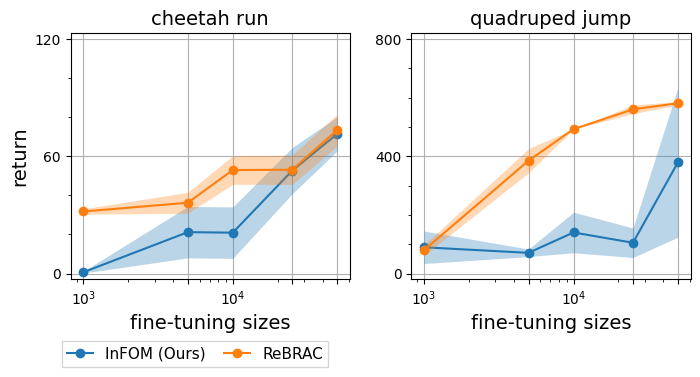

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8., 3.2), gridspec_kw=dict(wspace=0.22, hspace=0.5))

for (env_name, env_data), ax in zip(new_algo_data.items(), axes):
    for algo, data in env_data.items():
        x = data[0]
        y_mean = data[1]
        y_std = data[2]
        
        l, = ax.plot(x, y_mean, marker='o', label=algo, zorder=3)
        ax.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.3, lw=0, color=l.get_color(), zorder=3)

    if ax == axes[0]:
        ax.set_ylabel('return', fontsize=14)
        ax.set_ylim([-3, 120 + 3])
        ax.set_yticks([0, 60, 120])
        ax.yaxis.set_minor_locator(MultipleLocator(20))
        
        ax.legend(bbox_to_anchor=(-0.06, -0.22),
            loc="upper left", labelspacing=1, columnspacing=1.2075, fancybox=False,
            shadow=False, fontsize=11, borderpad=0.35, handlelength=1.7, ncol=4)
    elif ax == axes[1]:
        # ax.set_ylabel('return', fontsize=14)
        ax.set_ylim([-20, 820])
        ax.set_yticks([0, 400, 800])
        ax.yaxis.set_minor_locator(MultipleLocator(100))

    ax.set_xscale('log')
    ax.set_xticks([1000, 5000, 10000, 25000, 50000])

    # ax.set_ylabel('return', fontsize=14)
    # # ax.set_xlim([-4e2, 2e4 + 4e2])
    # ax.set_xscale('log')
    # ax.set_xticks([1000, 5000, 10000, 25000, 50000])
    # ax.set_ylim([-25, 825])
    # ax.set_yticks([0, 400, 800])
    # ax.yaxis.set_minor_locator(MultipleLocator(100))
    
    # ax.legend(bbox_to_anchor=(0.0, -0.2),
    #     loc="upper left", labelspacing=1, columnspacing=1.8075, fancybox=False,
    #     shadow=False, fontsize=12.5, borderpad=0.5, handlelength=1.7, ncol=3)
    # ax.legend()
    
    ax.set_title(env_name, fontsize=14)
    ax.set_xlabel('fine-tuning sizes', fontsize=14)
    # ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))  
    
    ax.grid(zorder=3)

fig.tight_layout()
filepath = "/u/cz8792/research/ogbench/plot_scripts/figures/dataset_size_ablation.pdf"
fig.savefig(filepath, dpi=150, bbox_inches="tight")
plt.show()
